In [150]:
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape
import PIL

import tensorflow_datasets as tfds

In [151]:
# Thor DataLoad
# Specify the path to the manually downloaded dataset
data_dir = r'C:\Users\thorp\OneDrive\Dokumenter\Uni\Kandidat\Anvendt maskinlæring\Exam\Data\patch_camelyon'
def normalize_image(image):
    # Ensure the pixel values are in the range [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    # You can also perform additional normalization, such as zero-centering
    # and scaling by the standard deviation if needed.
    # image = (image - tf.math.reduce_mean(image)) / tf.math.reduce_std(image)

    return image
# Load PatchCamelyon dataset using TFDS
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = normalize_image(image)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label# Here i make sure that labels are not passed through since the AE does not use labels

In [152]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:5%]'],
                        data_dir = data_dir,
                        download=False,
                        shuffle_files=True)

In [153]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)

In [154]:
latent_dim = 2
encoder = tf.keras.models.Sequential([
tf.keras.layers.Input(shape=(96, 96, 3)),
tf.keras.layers.Conv2D(32, 3, 2, activation='relu'),
tf.keras.layers.Conv2D(64, 3, 2, activation='relu'),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(2 * latent_dim),  # 2 for mean and standard deviation
])
encoder.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 47, 47, 32)        896       
                                                                 
 conv2d_31 (Conv2D)          (None, 23, 23, 64)        18496     
                                                                 
 flatten_15 (Flatten)        (None, 33856)             0         
                                                                 
 dense_28 (Dense)            (None, 4)                 135428    
                                                                 
Total params: 154,820
Trainable params: 154,820
Non-trainable params: 0
_________________________________________________________________


In [155]:
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=6*6*64, activation='relu', input_shape=(latent_dim,)),
    tf.keras.layers.Reshape(target_shape=(6, 6, 64)),  # To get in "image format"
    tf.keras.layers.Conv2DTranspose(128, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(3, 3, 2, padding='same', activation='sigmoid'),  # Adjust stride to get to 96x96x3
])

decoder.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 2304)              6912      
                                                                 
 reshape_14 (Reshape)        (None, 6, 6, 64)          0         
                                                                 
 conv2d_transpose_54 (Conv2D  (None, 12, 12, 128)      73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_55 (Conv2D  (None, 24, 24, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_56 (Conv2D  (None, 48, 48, 32)       18464     
 Transpose)                                                      
                                                     

In [156]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.decoder = decoder
    
    def encode(self, x):
        params = self.encoder(x)
        return tf.split(params, num_or_size_splits=2, axis=1) # mean, logvar
        
    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean #sigma= sqrt(exp(logvar))
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return tf.sigmoid(self.decode(eps))

In [157]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    vals = -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)
    return tf.reduce_sum(vals, axis=raxis)

def compute_loss(model, x):
    # Output from encoder
    mean, logvar = model.encode(x)    
    # The reparameterization trick
    z = model.reparameterize(mean, logvar)    
    # We assume that p(x|z) is multivariate Bernoulli, ie. the final dense layer 
    # has a sigmoid activation function, see page. 11
    # in Kingma, D. P., & Welling, M. (2013).
    x_logit = model.decode(z)

    # Ensure that x has the same shape as x_logit
    x = tf.image.resize(x, (x_logit.shape[1], x_logit.shape[2]), method='bilinear')

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, 
                                                        labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])    
    # Assume normaility of p(z)
    logpz = log_normal_pdf(z, 0., 0.)    
    # Assume normality of q(z|x)
    logqz_x = log_normal_pdf(z, mean, logvar)
    # -tf.reduce_mean(decoder + sampler - encoder)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [158]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [159]:
model = VAE(latent_dim, encoder, decoder)
optimizer = tf.keras.optimizers.Adam(1e-4)
test_sample = next(iter(test_dataset.take(1)))[:16]

def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('./vae-img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 0, Test set variational lower bound:-17073.15234375


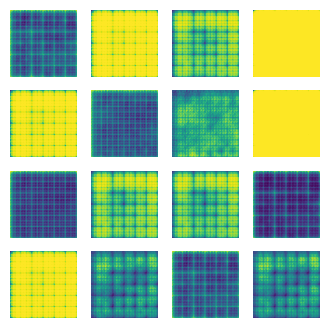

Epoch: 1, Test set variational lower bound:-16994.076171875


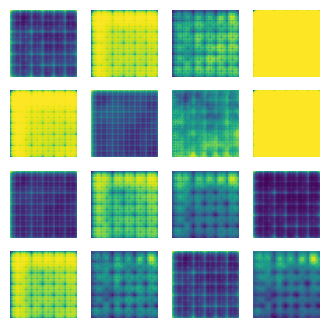

In [160]:
for epoch in range(2):
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    variational_lower_bound = -loss.result()

    print(f'Epoch: {epoch}, Test set variational lower bound:{variational_lower_bound}')
    generate_and_save_images(model, epoch, test_sample)

In [161]:
def display_image(epoch_no):
  return PIL.Image.open('./vae-img/image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

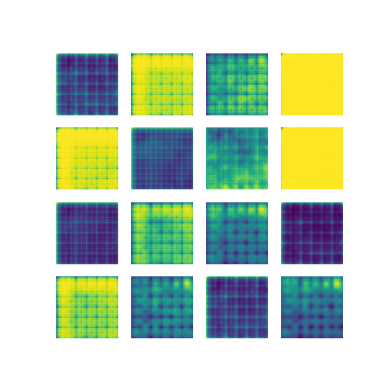

In [162]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

**CNN with VAE**